In [2]:
import pyreadstat
import pandas as pd
from imblearn.over_sampling import SMOTE

file_path = "ATP W89.sav"
df, meta = pyreadstat.read_sav(file_path)
# print(df.shape) # 164 columns

# initial filtering: drop clearly irrelevant
# keep columns with personal/demographic data, useful social media habits, target
df = df.drop(columns=["QKEY"])
interview_data = [x for x in df.columns if ("INTERVIEW" in x or "DEVICE" in x or "FORM" in x)] # asked ChatGPT for example subsetting list based on element values
df = df.drop(columns=interview_data)
# our target: how engaged individuals were
target = "ENGACTCT_W89"
# 2 features about social media habits selected from examining meaning in questionnaire/their metadata labels
sm_features = ["CLIMSEEK_W89","FOLCLIM_W89"]
# no longer need other questionnaire data, only using ENGACTCT to measure engagement, two social media habit cols relevant, personal data
personal_data = [x for x in df.columns if ("W89" not in x)]
keep_columns = personal_data + sm_features + [target]
df = df.loc[:,keep_columns]


def get_feat_vals_labels(column):
    print(df[column].value_counts())
    print(meta.variable_value_labels.get(column))

def get_na_columns():
    na_counts = pd.DataFrame({"na":df.isna().apply(sum)})
    na_columns = na_counts.loc[na_counts["na"]>0]
    return na_columns

# na_columns = get_na_columns()
# for col in na_columns.index:
#     get_feat_vals_labels(col)
df = df.drop(columns=["F_BORN","F_PARTYLN_FINAL"]) # dropped these columns b/c high proportion of NaNs & exist at least 1 other complete col describing similar data

# impute missing vals and 99.0s ('Refused') with mode
na_cols = get_na_columns().index
for i in range(len(df.columns)):
    column = df.columns[i]
    col_mode = df[column].mode()[0]
    if(column in na_cols):
        df[column] = df[column].fillna(col_mode)
    df[column] = df[column].apply(lambda x: col_mode if x==99.0 else x) # treat 99.0 ("Refused") as missing val
    # print(df[column].value_counts()) # verify no 99.0s remain

# Also want to recode the target feature -> target column name, values more interpretable:
df = df.rename(columns={"ENGACTCT_W89":"Engagement"})
df["Engagement"] = df["Engagement"].apply(lambda x: 1 if x>=2.0 else 0) # 1 represents active/engaged, 0 not

# Check for imbalances
print(df["Engagement"].value_counts()) # need to resample

# run SMOTE
smote = SMOTE(random_state=3001)
target = df["Engagement"]
feat_df = df.drop(columns=["Engagement"])
print(feat_df.shape,target.shape)
feat_df_balanced, target_balanced = smote.fit_resample(feat_df,target)
print(feat_df_balanced.shape,target_balanced.shape) # fix oversampling, then remember the recoding of target into >2, <=2

# Ready for PCA: missing vals addressed, all cols encoded, no need to scale b/c encoding addresses scale (e.g. income ranges instead of raw incomes), sampling done for imbalance

Engagement
0    12029
1     1720
Name: count, dtype: int64
(13749, 28) (13749,)
(24058, 28) (24058,)


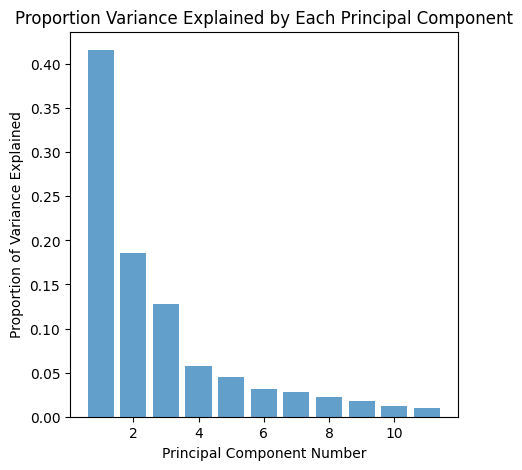

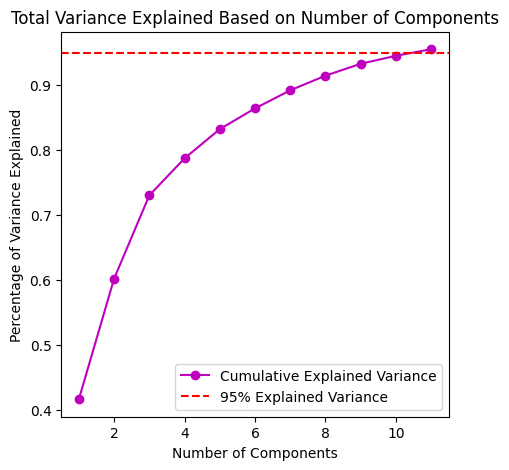

                      Cum_feature_weight
F_ATTEND                        2.027999
F_IDEO                          1.931894
F_PARTYSUM_FINAL                1.856653
F_BIRTHPLACE                    1.736405
F_EDUCCAT5                      1.731736
F_GENERATIONS                   1.583555
F_RACECMB                       1.575468
F_RELIG                         1.561815
F_PARTY_FINAL                   1.528174
F_RACETHNMOD                    1.524463
F_INC_SDT1                      1.519887
F_AGECAT                        1.497491
F_YEARSINUS                     1.463546
F_PARTYSUMIDEO_FINAL            1.434029
F_CDIVISION                     1.180024
F_EDUCCAT                       1.113071
F_INTFREQ                       0.638470
F_RELIGCAT1                     0.509095
F_CREGION                       0.494385
FOLCLIM_W89                     0.372444
F_VOLSUM                        0.355265
F_INC_TIER2                     0.291618
F_GENDER                        0.288748
F_HISP          

In [3]:
# PCA:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
def fit_pca(num_comp):
    pca = PCA(n_components=num_comp)
    pca.fit_transform(feat_df_balanced)
    return pca

def plot_pc_proportions(pca):
    pca_var_proportions = pca.explained_variance_ratio_
    plt.figure(figsize=[5,5])
    plt.bar(range(1,len(pca_var_proportions)+1),pca_var_proportions, alpha=0.7) #x-axis is PC #, y-axis is proportion of variance that PC explains
    plt.xlabel("Principal Component Number")
    plt.ylabel("Proportion of Variance Explained")
    plt.title("Proportion Variance Explained by Each Principal Component")
    return pca_var_proportions

def plot_cumulative_var(pca_var_proportions):
    cumulative_var = np.cumsum(pca_var_proportions) #each element is sum of any prev proportions + current
    plt.figure(figsize=[5,5])
    plt.plot(range(1,len(cumulative_var)+1),cumulative_var,marker='o',linestyle='-',color='m',label='Cumulative Explained Variance') # modeled after class pca notebook
    plt.xlabel("Number of Components")
    plt.ylabel("Percentage of Variance Explained")
    plt.title("Total Variance Explained Based on Number of Components")
    plt.axhline(y=0.95,color='r',linestyle='--',label="95% Explained Variance")
    plt.legend()
    plt.show()


pca = fit_pca(11) # adjustest arg until threshold reached: need 11 components to explain 95% variance
proportions = plot_pc_proportions(pca)
plot_cumulative_var(proportions)

initial_cum_weights = np.zeros(len(feat_df_balanced.columns)) # asked ChatGPT how to make a zero-initialized array
cum_weight_df = pd.DataFrame({"Cum_feature_weight":initial_cum_weights})
cum_weight_df.index = feat_df_balanced.columns

for i in range(0,11):
    pc = pca.components_[i]
    pc_df = pd.DataFrame({"Proportion of PC Calculation":pc})
    pc_df = pc_df.apply(abs)
    pc_df.index = feat_df_balanced.columns

    for column in feat_df_balanced.columns:
        rel_importance = pc_df.loc[column,"Proportion of PC Calculation"]
        cum_weight_df.loc[column,"Cum_feature_weight"] += rel_importance

cum_weight_df = cum_weight_df.sort_values(by="Cum_feature_weight",ascending=False)
print(cum_weight_df)


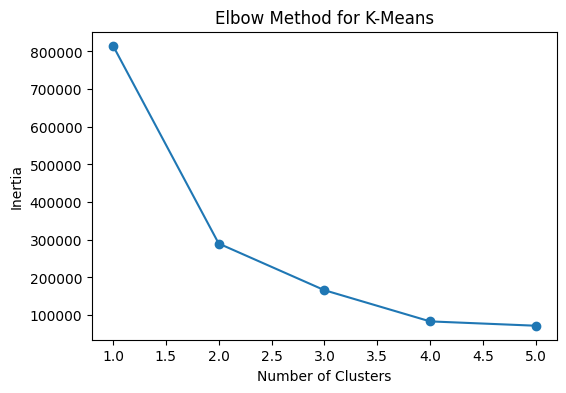

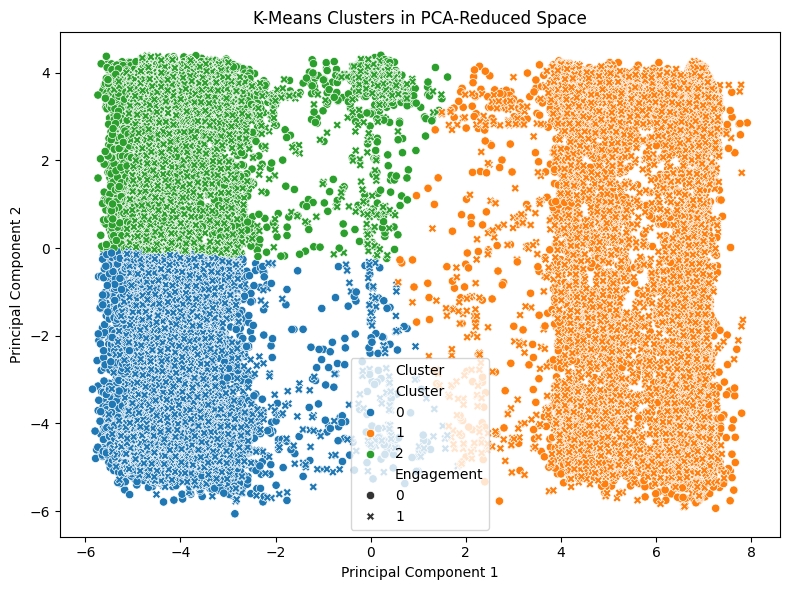

In [7]:
#K-means clustering
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(feat_df_balanced)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_vals = range(1, 6)

for k in k_vals:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca_2d)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_vals, inertia, marker='o')
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca_2d)
import seaborn as sns
import pandas as pd

# combine for plotting
pca_df = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])
pca_df["Cluster"] = clusters
pca_df["Engagement"] = target_balanced.reset_index(drop=True)  # optional: color by engagement label

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", style="Engagement")
plt.title("K-Means Clusters in PCA-Reduced Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


==== Decision Tree ====
Accuracy: 0.8947076752563037
F1 Score (macro): 0.8946346671321502
F1 Score (weighted): 0.8946346671321502
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      3609
           1       0.92      0.87      0.89      3609

    accuracy                           0.89      7218
   macro avg       0.90      0.89      0.89      7218
weighted avg       0.90      0.89      0.89      7218



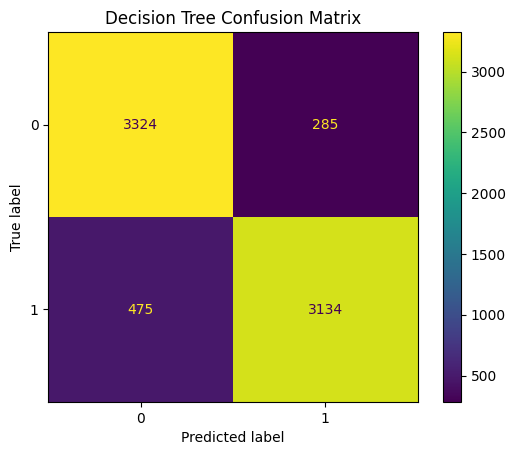

==== Random Forest ====
Accuracy: 0.9316985314491549
F1 Score (macro): 0.9316197490679148
F1 Score (weighted): 0.9316197490679147
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      3609
           1       0.96      0.90      0.93      3609

    accuracy                           0.93      7218
   macro avg       0.93      0.93      0.93      7218
weighted avg       0.93      0.93      0.93      7218



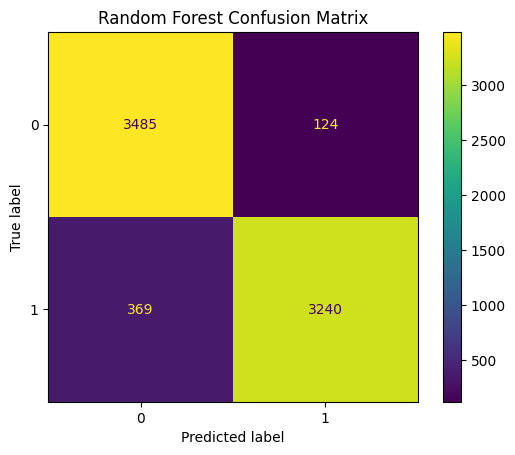

/var/folders/zq/wmk6jqm14dbbntwwr4r795440000gn/T/ipykernel_16407/694789799.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')


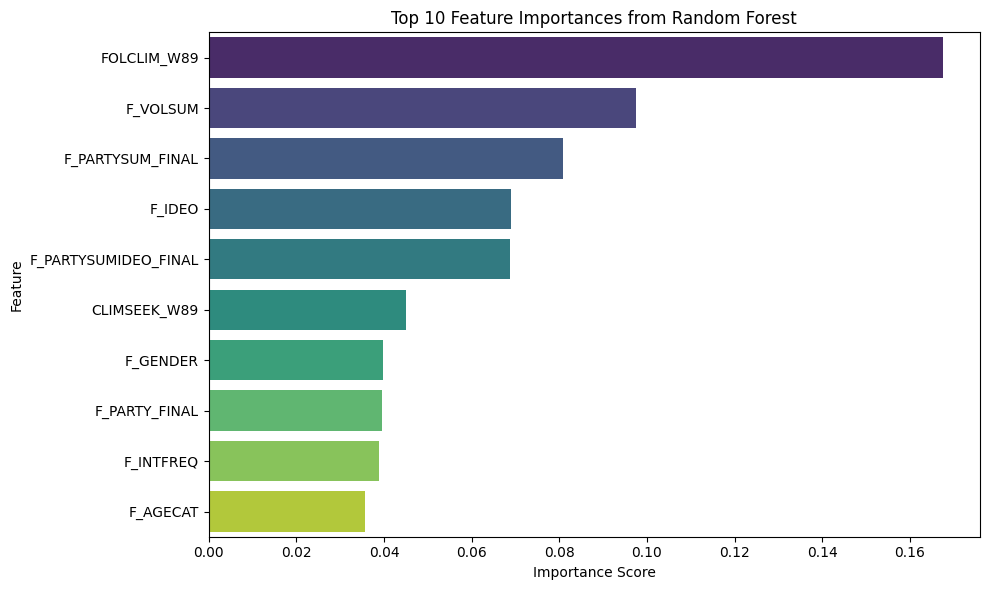

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    feat_df_balanced, target_balanced, test_size=0.3, random_state=42, stratify=target_balanced
)
dt_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1_weighted')
dt_grid.fit(X_train, y_train)

dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test)
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1_weighted')
rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
def evaluate_model(name, y_test, y_pred):
    print(f"==== {name} ====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
    print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    
evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)
importances = rf_best.feature_importances_
feat_names = feat_df_balanced.columns
importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


hello
